# **Credit Card Churn Modelling**
## Author: Mrunal Dodhiwala

# **Installing and Importing packages**

In [40]:
!pip install scikit-plot
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
import time
import warnings
import io
import copy as cp
from numpy import mean
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from xgboost.sklearn import XGBClassifier
from google.colab import files
from typing import Tuple

## **Importing and Inspecting the Dataset**

In [42]:
#Uploading dataset from local drive
uploaded = files.upload()

Saving Dataset_BankChurners.csv to Dataset_BankChurners (1).csv


In [43]:
#Reading the Dataset
df = pd.read_csv(io.BytesIO(uploaded['Dataset_BankChurners.csv']))

#Inspecting the Dataset
df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [44]:
#Checking the number of rows and columns in the dataset
df.shape

(10127, 20)

In [45]:
#Checking the number of 'Attrited' and 'Existing' customers
print(df.groupby(['Attrition_Flag']).Attrition_Flag.count())

Attrition_Flag
Attrited Customer    1627
Existing Customer    8500
Name: Attrition_Flag, dtype: int64


# **Data PreProcessing**

In [46]:
#Coding attrited customers as 1, and existing customers as 0
df.Attrition_Flag = df.Attrition_Flag.replace({'Existing Customer':0, 'Attrited Customer':1})

## One-Hot Encoding
Following attributes are Categorical Variables: Gender, Education Level, Marital Status, Income Category and Card Category. Each have various levels. Categorical varaibles need to be converted in a form that ML algorithms can do a better job in prediction.

One-Hot Encoding creates new variables for each level of an existing categorical variable, and assigns a binary value of 0 or 1 for that observation. Example: For the Gender attribute with 2 category levels of “F” and “M”, One-Hot Encoding will produce 2 variables: Gender.F and Gender.M. For a male customer, the value for Gender.F variable will be 0, and Gender.M will be 1.

In [47]:
#One-Hot Encoding
df_new=pd.get_dummies(df, columns=['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category'],drop_first=False)
df_new.columns

Index(['Attrition_Flag', 'Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Gender_F', 'Gender_M', 'Education_Level_College',
       'Education_Level_Doctorate', 'Education_Level_Graduate',
       'Education_Level_High School', 'Education_Level_Post-Graduate',
       'Education_Level_Uneducated', 'Education_Level_Unknown',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Unknown',
       'Income_Category_$120K +', 'Income_Category_$40K - $60K',
       'Income_Category_$60K - $80K', 'Income_Category_$80K - $120K',
       'Income_Category_Less than $40K', 'Income_Category_Unknown',
       'Card_Category_Blue', 'Card_Category_Gold', 'Card_Category_Plat

In [48]:
#Shape of the new dataset after One-Hot Encoding
df_new.shape

(10127, 38)

In [49]:
#Inspecting the Dataset
df_new.head()

,Attrition_Flag,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,0,45,3,39,5,1,3,12691.0,777,11914.0,...,0,0,1,0,0,0,1,0,0,0
1,0,49,5,44,6,1,2,8256.0,864,7392.0,...,0,0,0,0,1,0,1,0,0,0
2,0,51,3,36,4,1,0,3418.0,0,3418.0,...,0,0,0,1,0,0,1,0,0,0
3,0,40,4,34,3,4,1,3313.0,2517,796.0,...,0,0,0,0,1,0,1,0,0,0
4,0,40,3,21,5,1,0,4716.0,0,4716.0,...,0,0,1,0,0,0,1,0,0,0


## Train/Test split

Splitting the dataset in training and testing set in 70:30 ratio

In [50]:
#Define independent/dependent variables
X = df_new.drop(['Attrition_Flag'],axis=1)
y = df_new['Attrition_Flag']

#Train/test data in ratio 70:30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 11)

print(f"Length of test data after 70:30 split: {len(y_test)}\n")
print(f"Length of training data after 70:30 split: {len(y_train)}")
print(f"\tCount of attrited customers in training data : {sum(y_train==1)}")
print(f"\tCount of existing customers in training data: {sum(y_train==0)} \n")

Length of test data after 70:30 split: 3039

Length of training data after 70:30 split: 7088
	Count of attrited customers in training data : 1112
	Count of existing customers in training data: 5976 



## **Balancing the dataset with SMOTE**
The dataset is imbalanced with only 1627 'Attritited' customers out of 10127 total customers, representing 16% churn. With this imbalance, the learning models may create bias in prediction. Hence we are oversampling the minotority class "Attrited" customers to create a balanced set with 50% attrited and 50% existing customers.
We will be using SMOTE for over-sampling technique.

SMOTE is an oversampling technique where synthetic samples are generated for the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling.

We will be applying the machine learning models on both, the original dataset as well as on the SMOTE oversampled set. We will then evaluate each model performance pre and post balancing.

### Train/test split and Generating oversampled training data to balance the classes 50:50

Only the train dataset will be oversampled using SMOTE. Test set will be untouched.

In [51]:
#We have already defined independent/dependent variables
#X = df_new.drop(['Attrition_Flag'],axis=1)
#y = df_new['Attrition_Flag']

#Defining SMOTE
sampler = SMOTE(k_neighbors = 5, random_state = 11)

#Oversampling the train dataset using SMOTE. Test set will be untouched
X_sampler, y_sampler = sampler.fit_resample(X_train, y_train)

print("For the Non-normalized Dataset:")
print("Length of test set, before as well as after SMOTE oversampling:", len(X_test))

print("\nLength of train set, before SMOTE oversampling:", len(X_train))
print("Length of train set, after SMOTE oversampling:", len(X_sampler))

print("\tCount of 'Attrited' customers in oversampled data:",len(y_sampler[y_sampler==1]))
print("\tCount of 'Existing' customers in oversampled data:",len(y_sampler[y_sampler==0]))

print("\tProportion of 'Attrited' customers in oversampled data is:",len(y_sampler[y_sampler==1])/len(X_sampler))
print("\tProportion of 'Existing' customers in oversampled data is:",len(y_sampler[y_sampler==0])/len(X_sampler))

For the Non-normalized Dataset:
Length of test set, before as well as after SMOTE oversampling: 3039

Length of train set, before SMOTE oversampling: 7088
Length of train set, after SMOTE oversampling: 11952
	Count of 'Attrited' customers in oversampled data: 5976
	Count of 'Existing' customers in oversampled data: 5976
	Proportion of 'Attrited' customers in oversampled data is: 0.5
	Proportion of 'Existing' customers in oversampled data is: 0.5


Following are the sets now:

Original dataset: Training sets: X_train, y_train. Testing set: X_test, y_test

Balanced dataset: Training sets: X_sampler, y_sampler. Testing set: X_test, y_test

Length of training dataset after SMOTE oversampling is 11952; which is a balanced set with 5976 'attrited' and 5976 'existing' customers.

# **Modelling**

We will apply and evaluate 3 machine learning models:
- Logistic Regression
- Random Forest
- XGBoost

For each model, the following methodology will be followed:
- Training the model on the training dataset. Evaluate the time taken for training the model to measure the efficiency.
- With the trained model, Predicting the class attribute on the test dataset.
- Comparing the prediction vs actual class and visualizing with Confusion Matrix.
- 10-fold cross-validation for train/test split, and then evaluating the model on average Recall, Precision, F1 score, ROC-AUC, Accuracy. The cross-validation will indicate how stable the model is, and the average scores will be used to compare the 3 models.

This methodology will be followed on both, the original dataset as well as the SMOTE-balanced dataset, for each of the 3 proposed models.

### **k-fold Cross-Validation**
Since we will be comparing different ML algorithms, it is better to use k-fold Cross-Validation to evaluate the model performance.
Cross-Validation is a resampling procedure on a limited data sample. It is used in machine learning to estimate the skill of a machine learning model in making predictions on test data not used during the training of the model.

'k' refers to the number of groups that a given data sample is to be split into. We will be using 10-fold cross-validation.



## Defining functions
Since we will be carrying out the same steps for each of the models, it is better to define functions.

###Defining a function to print confusion matrix

In [52]:
def print_conf_mat(var_y_test, var_Y_predicted, model_name):
  #Function to print the Confision Matrix to compare the actual values of test set and predicted values of the model
  Conf_Mat = confusion_matrix(var_y_test, var_Y_predicted)

  plt.figure(figsize=(8, 6))
  ax = sns.heatmap(Conf_Mat, annot=True, fmt='d', cmap='Blues')
  ax.set_title("Confusion Matrix - " + model_name + "\n\n"); #Title
  
  #Axis
  ax.set_xlabel("\nPredicted")
  ax.set_ylabel("Actual");
  
  #Lables for class variable
  ax.xaxis.set_ticklabels(["Existing","Attrited"])
  ax.yaxis.set_ticklabels(["Existing","Attrited"])
  
  ## Display the visualization of the Confusion Matrix.
  plt.show()

###Defining a function to evaluate the average performance metrics of a model after 10-fold cross-validation on the original dataset

In [53]:
def model_scores(model, model_name):
  # Function to evaluate the performance of the machine learning models after 10-fold cross-validation
  
  # preparing the cross-validation procedure
  cv = KFold(n_splits=10, random_state=1, shuffle=True)
  
  # evaluating the model
  recall_scores = cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=-1)  #Recall = TP / (TP + FN)
  precision_scores = cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=-1)  #Precision = TP / (TP + FP)
  f1_scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)  #F1 = Combination of Recall Score and Precision Score
  roc_auc_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)  # Higher the ROC AUC, better the model
  accuracy_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)  #Accuracy = (TP + TN) / (TP + TN + FP + FN)
  
  # reporting the performance
  print(model_name + ' - Average Recall: %.2f ' % (mean(recall_scores)))
  print(model_name + ' - Average Precision: %.2f ' % (mean(precision_scores)))
  print(model_name + ' - Average F1: %.2f ' % (mean(f1_scores)))
  print(model_name + ' - Average ROC AUC: %.2f ' % (mean(roc_auc_scores)))
  print(model_name + ' - Average Accuracy: %.2f ' % (mean(accuracy_scores)))

###Defining a function to evaluate the average performance metrics of a model after 10-fold cross-validation on the SMOTE balanced dataset

The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, then evaluate the model on the stratified but non-transformed test set.
This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.

In [54]:
def model_scores_SMOTE(model, model_name):
  # Function to evaluate the performance of the machine learning models after 10-fold cross-validation
  
  # defining pipeline
  steps = [('over', SMOTE(k_neighbors = 5, random_state = 11)), ('model', model)]
  pipeline = Pipeline(steps=steps)

  # evaluating the pipeline
  cv = KFold(n_splits=10, random_state=1, shuffle=True)

  # evaluating the model
  recall_scores_Smote = cross_val_score(pipeline, X, y, scoring='recall', cv=cv, n_jobs=-1)  #Recall = TP / (TP + FN)
  precision_scores_Smote = cross_val_score(pipeline, X, y, scoring='precision', cv=cv, n_jobs=-1)  #Precision = TP / (TP + FP)
  f1_scores_Smote = cross_val_score(pipeline, X, y, scoring='f1', cv=cv, n_jobs=-1)  #F1 = Combination of Recall Score and Precision Score
  roc_auc_scores_Smote = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)  # Higher the ROC AUC, better the model
  accuracy_scores_Smote = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)  #Accuracy = (TP + TN) / (TP + TN + FP + FN)

  # reporting the performance
  print(model_name + ' after SMOTE - Average Recall: %.2f ' % (mean(recall_scores_Smote)))
  print(model_name + ' after SMOTE - Average Precision: %.2f ' % (mean(precision_scores_Smote)))
  print(model_name + ' after SMOTE - Average F1: %.2f ' % (mean(f1_scores_Smote)))
  print(model_name + ' after SMOTE - Average ROC AUC: %.2f ' % (mean(roc_auc_scores_Smote)))
  print(model_name + ' after SMOTE - Average Accuracy: %.2f ' % (mean(accuracy_scores_Smote)))

## **Logistic Regression model**
Logistic Regression is a popoular algorithm for binary classification problems, although Logistic Regression can be used for multinomial classification as well.
Logistic Regression estimates the probability of an event occuring based on certain independent factors. Logit function is used to bound the outcome between 0 and 1.

Some of the common use cases of Logistic Regression are: Fraud detection, diease likelihood, churn prediction.

### Logistic Regression (Original Dataset) - Training the model on the train dataset

In [55]:
#We will also measure the time taken to train the model

start = time.time() #Mark the Start time

#Building and training the Logistic Regression  model
Model_One = LogisticRegression(solver = "lbfgs", penalty = "l2", max_iter = 9999)
Model_One.fit(X_train, y_train.values.ravel())

end = time.time() #Mark the End time

print("The time (in seconds) for training the Logistic Regression model on original dataset is:", end-start)

The time (in seconds) for training the Logistic Regression model on original dataset is: 0.29050493240356445


### Logistic Regression (Original Dataset) - Predicting the class attribute for the test set

In [56]:
Y_Pred_LogReg = Model_One.predict(X_test)

### Logistic Regression (Original Dataset) - Generating the Confusion Matrix

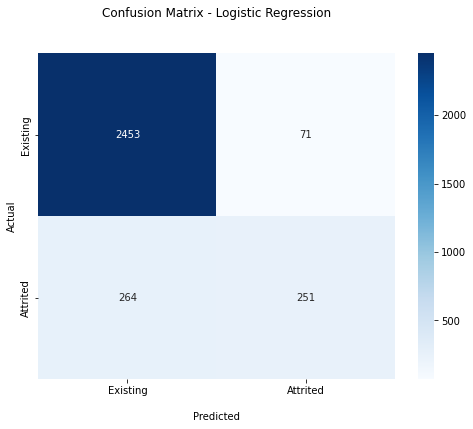

In [57]:
#Using the pre-defined function to generate the Confusion Matrix
print_conf_mat(y_test, Y_Pred_LogReg, "Logistic Regression")

### Logistic Regression (Original Dataset) with 10-fold Cross-Validation - Evaluation Metrics
The average scores of Recall, Precision, F1, ROC-AUC and Accuracy after 10-fold cross-validation will be used to compare the different ML models, before and after balancing

In [58]:
#Using the pre-defined function to print the evaluation metrics of Logistic Regression model on original dataset
model_scores(LogisticRegression(), "Logistic Regression")

Logistic Regression - Average Recall: 0.42 
Logistic Regression - Average Precision: 0.68 
Logistic Regression - Average F1: 0.52 
Logistic Regression - Average ROC AUC: 0.88 
Logistic Regression - Average Accuracy: 0.87 


## **Logistic Regression model on the balanced dataset after SMOTE**

### Logistic Regression (after SMOTE) - Training the model on the balanced train dataset

In [59]:
#We will also measure the time taken to train the model

start = time.time() #Mark the Start time

#Building and training the Logistic Regression  model on the SMOTE balanced dataset
#Model_One has been created above as LogisticRegression
Model_One.fit(X_sampler, y_sampler.values.ravel())

end = time.time() #Mark the End time

print("The time (in seconds) for training the Logistic Regression model on the SMOTE balanced dataset is:", end-start)

The time (in seconds) for training the Logistic Regression model on the SMOTE balanced dataset is: 10.686655044555664


### Logistic Regression (after SMOTE) - Predicting the class attribute for the test set

In [60]:
Y_Pred_LogReg_Smote = Model_One.predict(X_test)

### Logistic Regression (after SMOTE) - Generating the Confusion Matrix

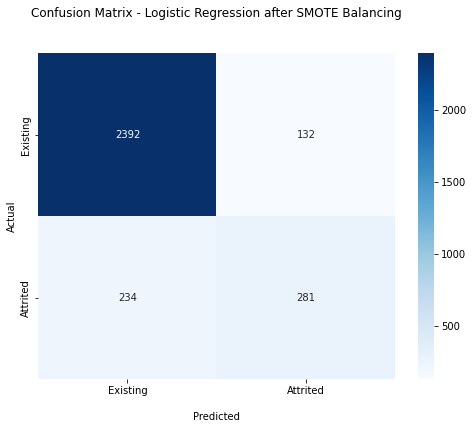

In [61]:
#Using the pre-defined function to generate the Confusion Matrix
print_conf_mat(y_test, Y_Pred_LogReg_Smote, "Logistic Regression after SMOTE Balancing")

### Logistic Regression (after SMOTE) with 10-fold Cross-Validation - Evaluation Metrics
The average scores of Recall, Precision, F1, ROC-AUC and Accuracy after 10-fold cross-validation will be used to compare the different ML models, before and after balancing

In [62]:
#Using the pre-defined function to print the evaluation metrics of Logistic Regression model on SMOTE balanced dataset
model_scores_SMOTE(LogisticRegression(), "Logistic Regression")

Logistic Regression after SMOTE - Average Recall: 0.78 
Logistic Regression after SMOTE - Average Precision: 0.45 
Logistic Regression after SMOTE - Average F1: 0.57 
Logistic Regression after SMOTE - Average ROC AUC: 0.88 
Logistic Regression after SMOTE - Average Accuracy: 0.81 


Recall has improved considerably from 42% to 78% after balancing the dataset with SMOTE

## **Random Forest model**
Random forest is a Supervised ML algorithm that is used widely in Classification and Regression problems. It builds decision trees on different samples and takes their majority vote for classification. It performs better results for classification problems.

Random Forest utilizes Bagging ensemble learning. Bagging (Bootstrap Aggregation) involves creating different training subsets with replacement from the sample training data. Independent decision trees are contstructed on each subset generating an output for each subset. The final output is based on majority voting from each decision tree.

Random Forest reduces the overfitting problem of decision trees, and increases precision.

### Random Forest (Original Dataset) - Training the model on the train dataset

In [63]:
#We will also measure the time taken to train the model

start = time.time() #Mark the Start time

#Building and training the Random Forest  model
Model_Two = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth=10, random_state = 1)
Model_Two.fit(X_train, y_train.values.ravel())

end = time.time() #Mark the End time

print("The time (in seconds) for training the Random Forest model on original dataset is:", end-start)

The time (in seconds) for training the Random Forest model on original dataset is: 1.2859678268432617


### Random Forest (Original Dataset) - Predicting the class attribute for the test set

In [64]:
Y_Pred_RF = Model_Two.predict(X_test)

### Random Forest (Original Dataset) - Generating the Confusion Matrix

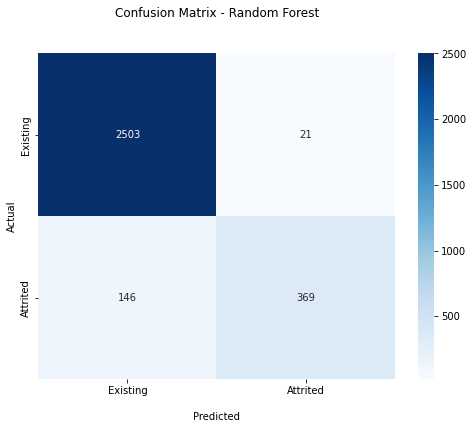

In [65]:
#Using the pre-defined function to generate the Confusion Matrix
print_conf_mat(y_test, Y_Pred_RF, "Random Forest")

### Random Forest (Original Dataset) with 10-fold Cross-Validation - Evaluation Metrics
The average scores of Recall, Precision, F1, ROC-AUC and Accuracy after 10-fold cross-validation will be used to compare the different ML models, before and after balancing


In [66]:
#Using the pre-defined function to print the evaluation metrics of Random Forest model
model_scores(Model_Two, "Random Forest")

Random Forest - Average Recall: 0.75 
Random Forest - Average Precision: 0.92 
Random Forest - Average F1: 0.82 
Random Forest - Average ROC AUC: 0.99 
Random Forest - Average Accuracy: 0.95 


## **Random Forest model on the balanced dataset after SMOTE**

### Random Forest (after SMOTE) - Training the model on the balanced train dataset

In [67]:
#We will also measure the time taken to train the model

start = time.time() #Mark the Start time

#Building and training the Random Forest model on the SMOTE balanced dataset
#Model_Two has been created above as RandomForestClassifier
Model_Two.fit(X_sampler, y_sampler.values.ravel())

end = time.time() #Mark the End time

print("The time (in seconds) for training the Random Forest model on the SMOTE balanced dataset is:", end-start)

The time (in seconds) for training the Random Forest model on the SMOTE balanced dataset is: 2.1587913036346436


### Random Forest (after SMOTE) - Predicting the class attribute for the test set

In [68]:
Y_Pred_RF_Smote = Model_Two.predict(X_test)

### Random Forest (after SMOTE) - Generating the Confusion Matrix

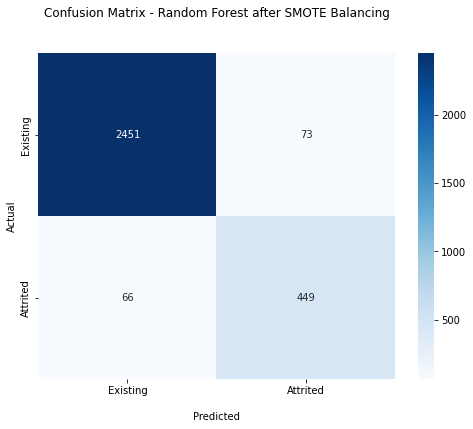

In [69]:
#Using the pre-defined function to generate the Confusion Matrix
print_conf_mat(y_test, Y_Pred_RF_Smote, "Random Forest after SMOTE Balancing")

### Random Forest (after SMOTE) with 10-fold Cross-Validation - Evaluation Metrics
The average scores of Recall, Precision, F1, ROC-AUC and Accuracy after 10-fold cross-validation will be used to compare the different ML models, before and after balancing

In [70]:
#Using the pre-defined function to print the evaluation metrics of Random Forest model on SMOTE balanced dataset
model_scores_SMOTE(Model_Two, "Random Forest")

Random Forest after SMOTE - Average Recall: 0.87 
Random Forest after SMOTE - Average Precision: 0.83 
Random Forest after SMOTE - Average F1: 0.85 
Random Forest after SMOTE - Average ROC AUC: 0.98 
Random Forest after SMOTE - Average Accuracy: 0.95 


## **XGBoost Regressor model**
The XGBoost or Extreme Gradient Boosting algorithm is a decision tree based machine learning algorithm that uses gradient boosting process to help improve performance.

Boosting is an ensemble technique where new models are added to correct the errors made by existing models. Gradient boosting is an approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.

Currently, XGBoost is the leading machine learning library for regression, classification, and ranking problems. It outperforms most supervised ML algorithms on speed and model performance.

### XGBoost (Original Dataset) - Training the model on the train dataset

In [71]:
#We will also measure the time taken to train the model

start = time.time() #Mark the Start time

#Building and training the XGBoost  model
Model_Three = XGBClassifier()
Model_Three.fit(X_train, y_train.values.ravel())

end = time.time() #Mark the End time

print("The time (in seconds) for training the XGBoost model on original dataset is:", end-start)

The time (in seconds) for training the XGBoost model on original dataset is: 0.8817574977874756


### XGBoost (Original Dataset) - Predicting the class attribute for the test set

In [72]:
Y_Pred_XGB = Model_Three.predict(X_test)

### XGBoost (Original Dataset) - Generating the Confusion Matrix

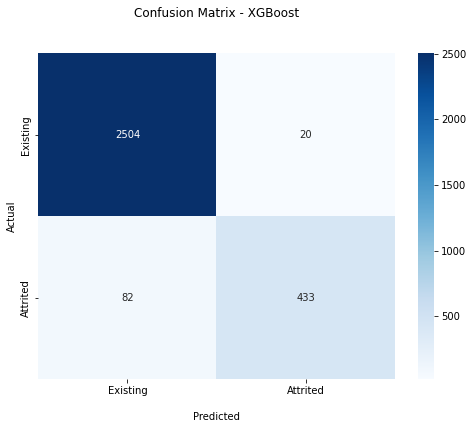

In [73]:
#Using the pre-defined function to generate the Confusion Matrix
print_conf_mat(y_test, Y_Pred_XGB, "XGBoost")

### XGBoost (Original Dataset) with 10-fold Cross-Validation - Evaluation Metrics
The average scores of Recall, Precision, F1, ROC-AUC and Accuracy after 10-fold cross-validation will be used to compare the different ML models, before and after balancing

In [74]:
#Using the pre-defined function to print the evaluation metrics of XGBoost model
model_scores(Model_Three, "XGBoost")

XGBoost - Average Recall: 0.84 
XGBoost - Average Precision: 0.93 
XGBoost - Average F1: 0.88 
XGBoost - Average ROC AUC: 0.99 
XGBoost - Average Accuracy: 0.97 


## **XGBoost model on the balanced dataset after SMOTE**

### XGBoost (after SMOTE) - Training the model on the balanced train dataset

In [75]:
#We will also measure the time taken to train the model

start = time.time() #Mark the Start time

#Building and training the XGBoost model on the SMOTE balanced dataset.
#Model_Three has been created earlier as XGBClassifier()
Model_Three.fit(X_sampler, y_sampler.values.ravel())

end = time.time() #Mark the End time

print("The time (in seconds) for training the XGBoost model on the SMOTE balanced dataset is:", end-start)

The time (in seconds) for training the XGBoost model on the SMOTE balanced dataset is: 1.5091297626495361


### XGBoost (after SMOTE) - Predicting the class attribute for the test set

In [76]:
Y_Pred_XGB_Smote = Model_Three.predict(X_test)

### XGBoost (after SMOTE) - Generating the Confusion Matrix

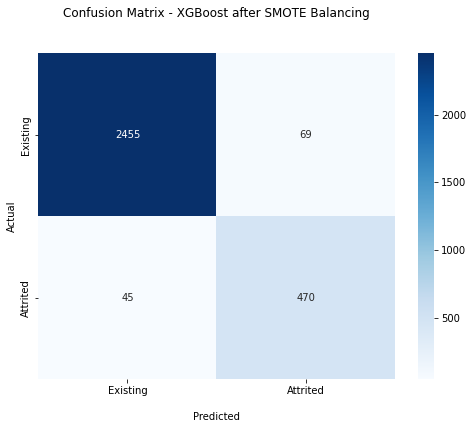

In [77]:
#Using the pre-defined function to generate the Confusion Matrix
print_conf_mat(y_test, Y_Pred_XGB_Smote, "XGBoost after SMOTE Balancing")

### XGBoost (after SMOTE) with 10-fold Cross-Validation - Evaluation Metrics
The average scores of Recall, Precision, F1, ROC-AUC and Accuracy after 10-fold cross-validation will be used to compare the different ML models, before and after balancing

In [78]:
#Using the pre-defined function to print the evaluation metrics of XGBoost model on SMOTE balanced dataset
model_scores_SMOTE(Model_Three, "XGBoost")

XGBoost after SMOTE - Average Recall: 0.90 
XGBoost after SMOTE - Average Precision: 0.86 
XGBoost after SMOTE - Average F1: 0.88 
XGBoost after SMOTE - Average ROC AUC: 0.99 
XGBoost after SMOTE - Average Accuracy: 0.96 


#END